**Note:**

This version focusses on training a NN that can perform well for a range of global pauli y biases as those are the bias the MWPM performs poorly against.

In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(64)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 53.30%


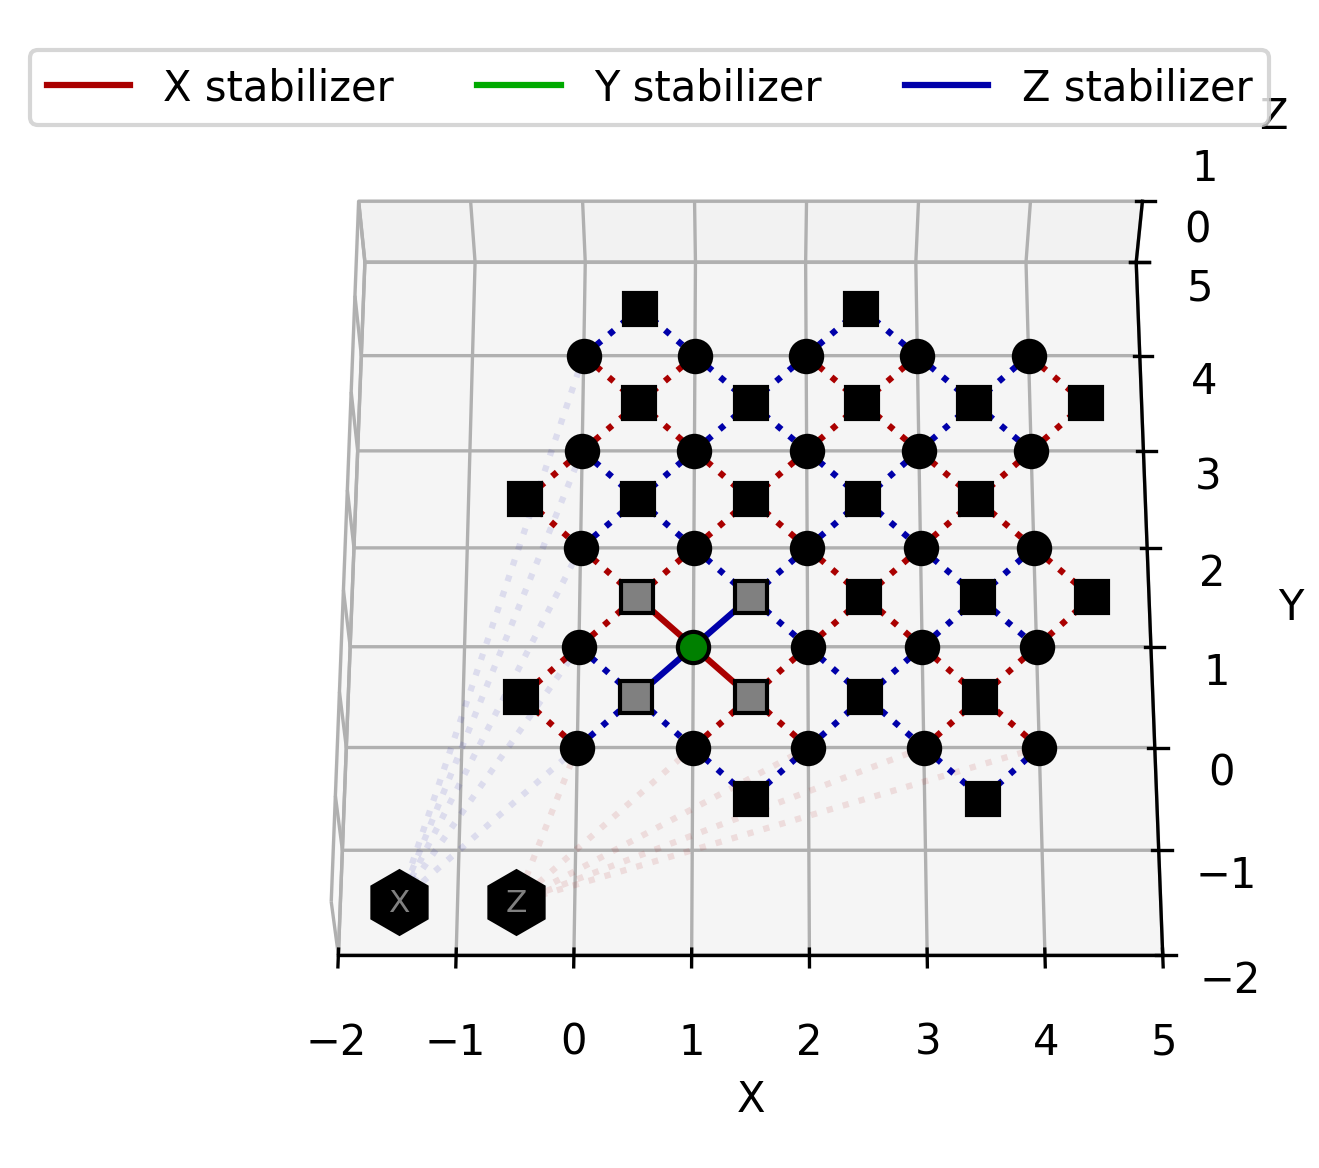

In [2]:
p = .03
nu = 100
error_prob = [
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
    1 / (2 * (nu + 1)) * p,
]
# error_prob = [.01, .01, .01]
code_distance = 5

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=10, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

# Create data function

In [3]:
def jax_create_error_batch(px: float, py: float, pz: float, size: int, batch_size: int, key) -> jnp.ndarray:
    rand = jax.random.uniform(key, shape=(batch_size, size), dtype=jnp.float32)
    result = jnp.zeros_like(rand, dtype=jnp.int32)  # Initialize with zeros (default case)

    # Apply conditions sequentially
    result = jnp.where(rand < px + py + pz, 1, result)  # Check for px+py+pz first
    result = jnp.where(rand < py + pz, 2, result)      # Check for py+pz next
    result = jnp.where(rand < pz, 3, result)          # Check for pz last

    return result

jax_create_error_batch_jit = jax.jit(jax_create_error_batch, static_argnames=["size", "batch_size"])

def gen_data(error_prob: list, info: dict, ndq: int, batch_size: int, key):
    errors = jax_create_error_batch(*error_prob, size=ndq, batch_size=batch_size, key=key)

    syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
    logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

    return syndromes, logicals

subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=10, key=subkey)
print("Syndromes:")
print(syndromes)
print("\nLogicals:")
print(logicals)

Syndromes:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Logicals:
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]


# Create the NN

In [4]:
def NN(syndromes, error_weights, params):
    # Change from 0, 1 inputs to -1, 1
    syndromes = jnp.append(2*syndromes - 1, error_weights)

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        syndromes = jnp.matmul(w, syndromes) + b
        if layer_idx < num_layers-1:
            syndromes = jax.nn.relu(syndromes)
    return syndromes


NN_batch = jax.vmap(NN, in_axes=[0, None, None], out_axes=0)

# Initialize the NN
with random weights and biases

In [5]:
subkey, key = jax.random.split(key)
num_neurons_layers = [nsq+3, 100, 100, 50, 2]
params = NN_init_params( subkey, num_neurons_layers )
print(f"Layers: {num_neurons_layers}")

b_count = 0
for b in params['biases']:
    b_count += b.shape[0]
print(f'Bias parameters: {b_count}')

w_count = 0
for w in params['weights']:
    w_count += w.shape[0] * w.shape[1]
print(f'Weight parameters: {w_count}')

print(f'Total: {b_count+w_count}')

Layers: [27, 100, 100, 50, 2]
Bias parameters: 252
Weight parameters: 17800
Total: 18052


# Cost function

In [6]:
def mse_loss_batch(NN_input: list[jnp.ndarray], params: dict, logicals: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
    """
    NN_logicals = NN_batch(*NN_input, params)
    return optax.sigmoid_binary_cross_entropy(NN_logicals, logicals).mean()

mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit(mse_loss_batch_val_grad)

# Test it on the randomly initiated NN

In [7]:
# Generate data
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=1000, key=subkey)

error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
print(error_weights)
print()

NN_input = [syndromes, error_weights]

# Run the neural network
NN_probs = jax.nn.sigmoid(NN_batch(*NN_input, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)
print(NN_probs)

# Evaluate the neural networks performance
loss = mse_loss_batch(NN_input, params, logicals)

[2.5066986 1.        2.5066986]

[[0.51595163 0.27513385]
 [0.542312   0.23754823]
 [0.59820515 0.3495206 ]
 ...
 [0.4720245  0.28657344]
 [0.4720245  0.28657344]
 [0.542312   0.23754823]]


# Train the NN

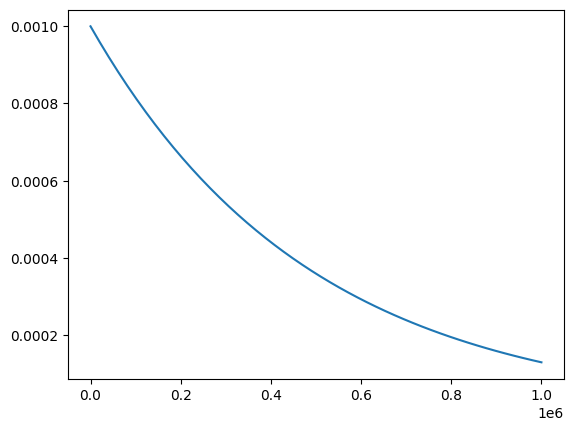

In [8]:
init_value = 1E-3
transition_steps = 25_000
decay_rate = 0.95

count = jnp.linspace(0, 1_000_000)

rate_factor = count / transition_steps
decayed_value = init_value * (decay_rate ** rate_factor)

plt.figure()
plt.plot(count, decayed_value)
plt.show()

learning_rate = optax.exponential_decay(
    init_value = 1E-3,
    transition_steps = 50_000,
    decay_rate = 0.95
)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

loss_data = []
idx_batch = 0
T = {
    'Progress update ': 0,
    'Data generation ': 0, 
    'loss + grad calc': 0, 
    'Safe guard      ': 0, 
    'Update          ': 0, 
    'Store           ': 0}

In [9]:
# training parameters
max_training_batches = 400_000
# max_training_time = 60*60 # in seconds
batch_size = 32
p_tot = .03
nu_range = [1/2, 1/2]

num_batch_generation_size = 100_000 // batch_size
print(num_batch_generation_size)

progress_updates_step = 10*num_batch_generation_size
losses = [loss for _ in range(progress_updates_step)]

subkey, key = jax.random.split(key)
syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)

3125


In [10]:
@jax.jit
def update(params, grads, opt_state):
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [11]:
from time import time

while idx_batch < max_training_batches: 
    try:
        t0 = time()

        # Generate data
        if idx_batch % progress_updates_step == 0:
            # Give an update on progress
            improvement_rate, _ = np.polyfit(np.linspace(0,1,progress_updates_step), losses, deg=1)
            score = np.mean(losses)
            print(f"{score = :7.5f} with an improvement rate of {improvement_rate:8.5f} | grad/val = {improvement_rate/score:8.5f} | Learning rate = {init_value * (decay_rate**(idx_batch / transition_steps)):10.8f} | {idx_batch = }")
        
        t1 = time()
        T['Progress update '] += t1 - t0
        t0 = t1
        
        if idx_batch % num_batch_generation_size == 0:
            score = np.mean(losses)
            loss_data.append(score)
            # Generate new data
            subkey, nu_subkey, key = jax.random.split(key, 3)
            nu = jnp.exp(jax.random.uniform(nu_subkey, shape=1, minval=jnp.log(nu_range[0]), maxval=jnp.log(nu_range[1])))[0]
            error_prob = [
                1 / (2 * (nu + 1)) * p_tot,
                nu / (nu + 1) * p_tot,
                1 / (2 * (nu + 1)) * p_tot,
            ]
            error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
            syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)
        syndromes = syndromes_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]
        logicals = logicals_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]

        t1 = time()
        T['Data generation '] += t1 - t0
        t0 = t1
        
        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad([syndromes, error_weights], params, logicals)

        t1 = time()
        T['loss + grad calc'] += t1 - t0
        t0 = t1

        # Update params
        params, opt_state = update(params, grads, opt_state)

        t1 = time()
        T['Update          '] += t1 - t0
        t0 = t1

        # add the loss to the list:
        losses[idx_batch % progress_updates_step] = loss
        idx_batch += 1

        t1 = time()
        T['Store           '] += t1 - t0
        t0 = t1
    except KeyboardInterrupt:
        print('Manually stopped')
        break


score = 0.61170 with an improvement rate of  0.00000 | grad/val =  0.00000 | Learning rate = 0.00100000 | idx_batch = 0
score = 0.01525 with an improvement rate of -0.02767 | grad/val = -1.81424 | Learning rate = 0.00093790 | idx_batch = 31250
score = 0.00823 with an improvement rate of -0.00113 | grad/val = -0.13745 | Learning rate = 0.00087965 | idx_batch = 62500
score = 0.00753 with an improvement rate of -0.00030 | grad/val = -0.04024 | Learning rate = 0.00082502 | idx_batch = 93750
Manually stopped


In [12]:
np.mean(loss_data[-len(loss_data) // 4:])

0.0026547944

In [14]:
for k,v in T.items():
    print(f"{k}: {v:10.3f}s ({v/sum(T.values()):6.2%})")

Progress update :     62.814s ( 2.43%)
Data generation :   1390.716s (53.85%)
loss + grad calc:    308.831s (11.96%)
Safe guard      :      0.000s ( 0.00%)
Update          :    754.180s (29.20%)
Store           :     65.869s ( 2.55%)


In [15]:
save_NN('geometry_ybias_adaptive_8.json', params)

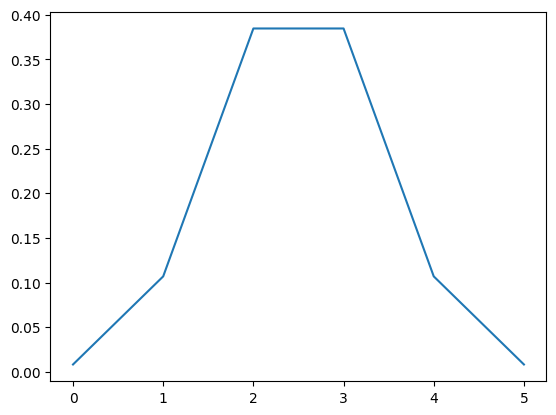

In [18]:
window_size = len(loss_data) // 5
window_xs = np.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)

plt.plot(range(window_size), window)

In [16]:
losses_jax = jnp.array(loss_data)

In [17]:
jnp.save('geometry_ybias_adaptive_8', losses_jax)

In [19]:
losses_ = jnp.ones(shape=(losses_jax.shape[0]+2*window_size))
a = window_size
b = a + losses_jax.shape[0]
losses_ = losses_.at[a:b].set(losses_jax)
losses_ = losses_.at[:a].set(losses_jax[:a][::-1])
losses_ = losses_.at[b:].set(losses_jax[-a:][::-1])
running_avg = jnp.convolve(losses_, window, mode='same')[a:b]

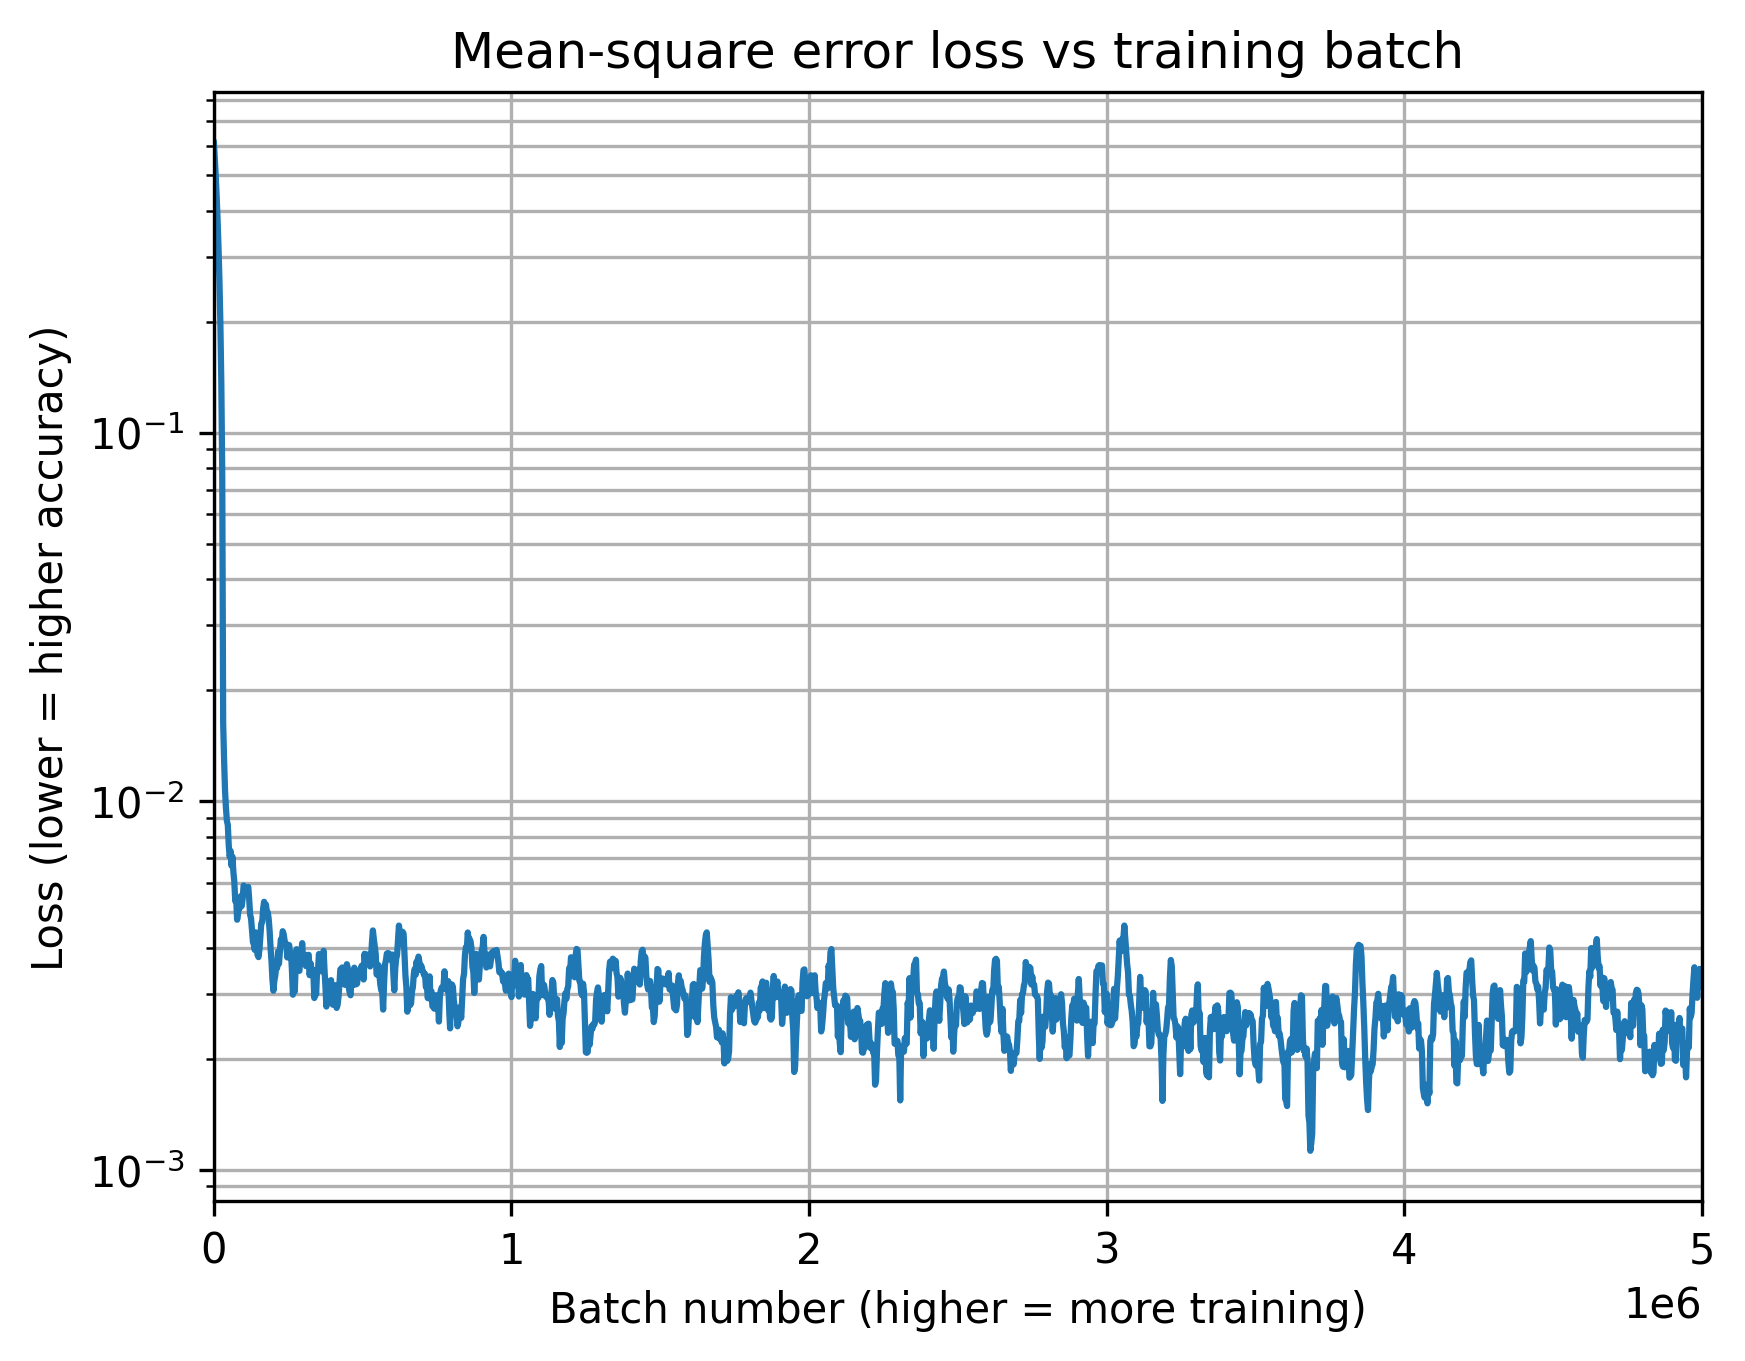

In [23]:
plt.figure(dpi=300)
plt.plot(num_batch_generation_size*jnp.arange(0, losses_jax.shape[0]), losses_jax, '-', label="Raw data")
# plt.plot(jnp.arange(0, losses_jax.shape[0]), running_avg, label="Running AVG", c='k')
# plt.hist2d(jnp.arange(0, len(loss_data)), losses_jax, bins=(
#     jnp.linspace(0, len(loss_data), 128),
#     # jnp.arange(0, len(loss_data), 25_000),
#     jnp.logspace(-6, 1, 128)
# ), cmap='viridis')
plt.xlim(0, max_training_batches)
# plt.ylim(ymin = running_avg.min())
# plt.legend()
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.xlabel("Batch number (higher = more training)")
plt.ylabel("Loss (lower = higher accuracy)")
plt.grid(which='both')
plt.show()

In [26]:
params_ = load_NN("geometry_ybias_adaptive_8.json")
NN_batch(jnp.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), error_weights, params)

Array([[-16.101969, -15.825221]], dtype=float32)

In [23]:
print(syndromes[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
# Generate data
batch_size = 1_000_000
p = .03
nu = 1/2
error_prob = [
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
    1 / (2 * (nu + 1)) * p,
]
error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
# error_prob = [.01, .01, .01]
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)


In [13]:
# Run the neural network and round it's prediction to the nearest integer
NN_probs = jax.nn.sigmoid(NN_batch(syndromes, error_weights, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)

In [14]:
# Evaluate the MWPM decoder on the same dataset
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

In [15]:
NN_errors = (logicals+NN_logicals)%2
NN_rates = [
    jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

MWPM_errors = (logicals+MWPM_logicals)%2
MWPM_rates = [
    jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

In [16]:
print("\t\t\tPauli-X\tPauli-Y\tPauli-Z")
print(f"Physical error rates:\t\t{error_prob[0]:7.2E}\t{error_prob[1]:7.2E}\t{error_prob[2]:7.2E}")
print(f"NN prediction error rates:\t{NN_rates[0]:7.2E}\t{NN_rates[1]:7.2E}\t{NN_rates[2]:7.2E}")
print(f"MWPM decoding error rates:\t{MWPM_rates[0]:7.2E}\t{MWPM_rates[1]:7.2E}\t{MWPM_rates[2]:7.2E}")

			Pauli-X	Pauli-Y	Pauli-Z
Physical error rates:		1.00E-02	1.00E-02	1.00E-02
NN prediction error rates:	2.13E-03	5.30E-05	1.80E-03
MWPM decoding error rates:	1.94E-03	2.70E-05	1.97E-03


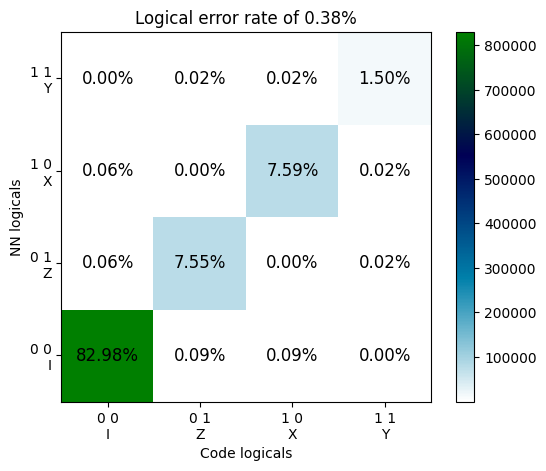

In [36]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * NN_logicals[:, 0] + NN_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('NN logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

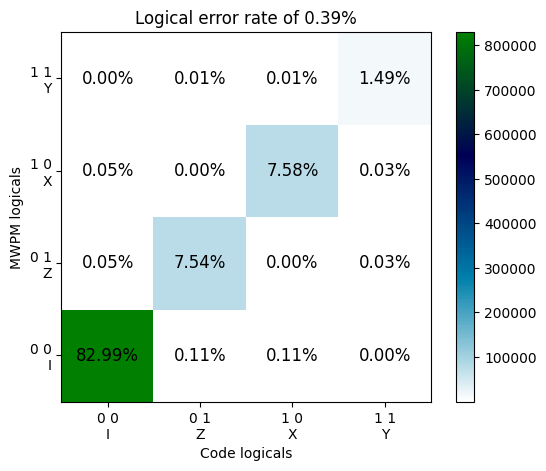

In [37]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * MWPM_logicals[:, 0] + MWPM_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('MWPM logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

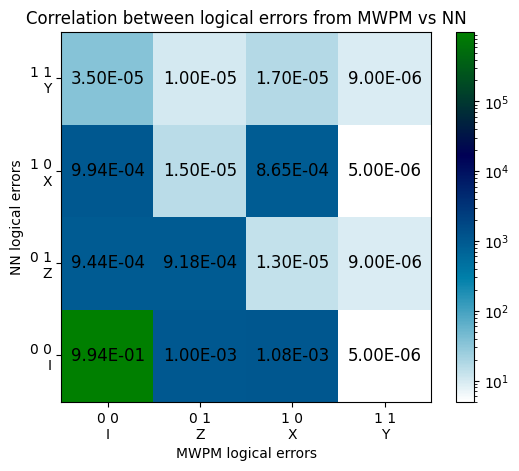

In [38]:
from matplotlib.colors import LogNorm

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * MWPM_errors[:, 0] + MWPM_errors[:, 1]
j = 2 * NN_errors[:, 0] + NN_errors[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r', norm=LogNorm())
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('MWPM logical errors')
plt.ylabel('NN logical errors')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():7.2E}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Correlation between logical errors from MWPM vs NN')
plt.show()

In [39]:
bias = jnp.logspace(jnp.log10(1/2), jnp.log10(100))
bias = jnp.linspace(1/2, 100, 2000)
losses = []
batch_size = 100_000
p = .03
for nu in bias:
    # Generate data
    error_prob = [
        1 / (2 * (nu + 1)) * p,
        nu / (nu + 1) * p,
        1 / (2 * (nu + 1)) * p,
    ]
    error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
    # error_prob = [.01, .01, .01]
    subkey, key = jax.random.split(key)
    syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)

    losses.append(mse_loss_batch([syndromes, error_weights], params, logicals))

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Data
x = bias
y = jnp.array(losses)

def power_law(x, a, b, c):
    return a * x**(-b) + c

# Fit the data to both models
power_params, _ = curve_fit(power_law, x, y, p0=[0.01, 0.5, 0.002])

mask = x > 0
poly_params = np.polyfit(x[mask], y[mask], deg=4)
poly_fit = np.poly1d(poly_params)

# Generate fitted data
y_fit = power_law(x, *power_params)

# Plot data and fits
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Data", color="black")
plt.plot(x, y_fit, label=f"Power Law\nParams:\n{power_params}", color="red")
plt.plot(x, poly_fit(x), label=f"Poly fit\nParams:\n{poly_fit.coefficients}", color="blue")
plt.xlabel("y-bias")
plt.ylabel("Loss")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Fitting Data to Exponential Decay and Power Law")
plt.show()

power_params
